In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE

In [80]:
# Load the dataset
file_path = 'Maternal Health Risk Data Set.csv'
data = pd.read_csv(file_path)
data.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


EDA and Pre-processing

In [81]:
# Display information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [82]:
# Display statistical summary of the dataset
data.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


check if there are any missing values 

In [83]:
data.isna().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

In [84]:
# Check for imbalance in the target variable
risk_counts = data['RiskLevel'].value_counts()
print("\nRisk Level Distribution:")
print(risk_counts)


Risk Level Distribution:
RiskLevel
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64


there is no imbalance 

In [85]:
#  Print unique values and data type of 'RiskLevel'
print("Unique values in 'RiskLevel' column before encoding:", data['RiskLevel'].unique())
print("Data type of 'RiskLevel' column before encoding:", data['RiskLevel'].dtype)


Unique values in 'RiskLevel' column before encoding: ['high risk' 'low risk' 'mid risk']
Data type of 'RiskLevel' column before encoding: object


Encoding categorical variable

In [86]:

# Encode the 'RiskLevel' column
label_encoder = LabelEncoder()
data['RiskLevel'] = label_encoder.fit_transform(data['RiskLevel'])
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 55.6 KB


risk level high 0 , mid 1 , low 2.

In [87]:
# Debugging: Print unique values and data type of 'RiskLevel' after encoding
print("Unique values in 'RiskLevel' column after encoding:", data['RiskLevel'].unique())
print("Data type of 'RiskLevel' column after encoding:", data['RiskLevel'].dtype)

Unique values in 'RiskLevel' column after encoding: [0 1 2]
Data type of 'RiskLevel' column after encoding: int64


In [88]:
# Ensure the 'RiskLevel' column is integer type
assert data['RiskLevel'].dtype == 'int32' or data['RiskLevel'].dtype == 'int64', "RiskLevel should be integer type"


we had an issue where after categorical mapping we lost some values , but fixed it here

In [89]:
# Check distribution after mapping
print("\nMapped Risk Level Distribution:")
mapped_risk_counts = data['RiskLevel'].value_counts()
print(mapped_risk_counts)


Mapped Risk Level Distribution:
RiskLevel
1    406
2    336
0    272
Name: count, dtype: int64


Data Visualization

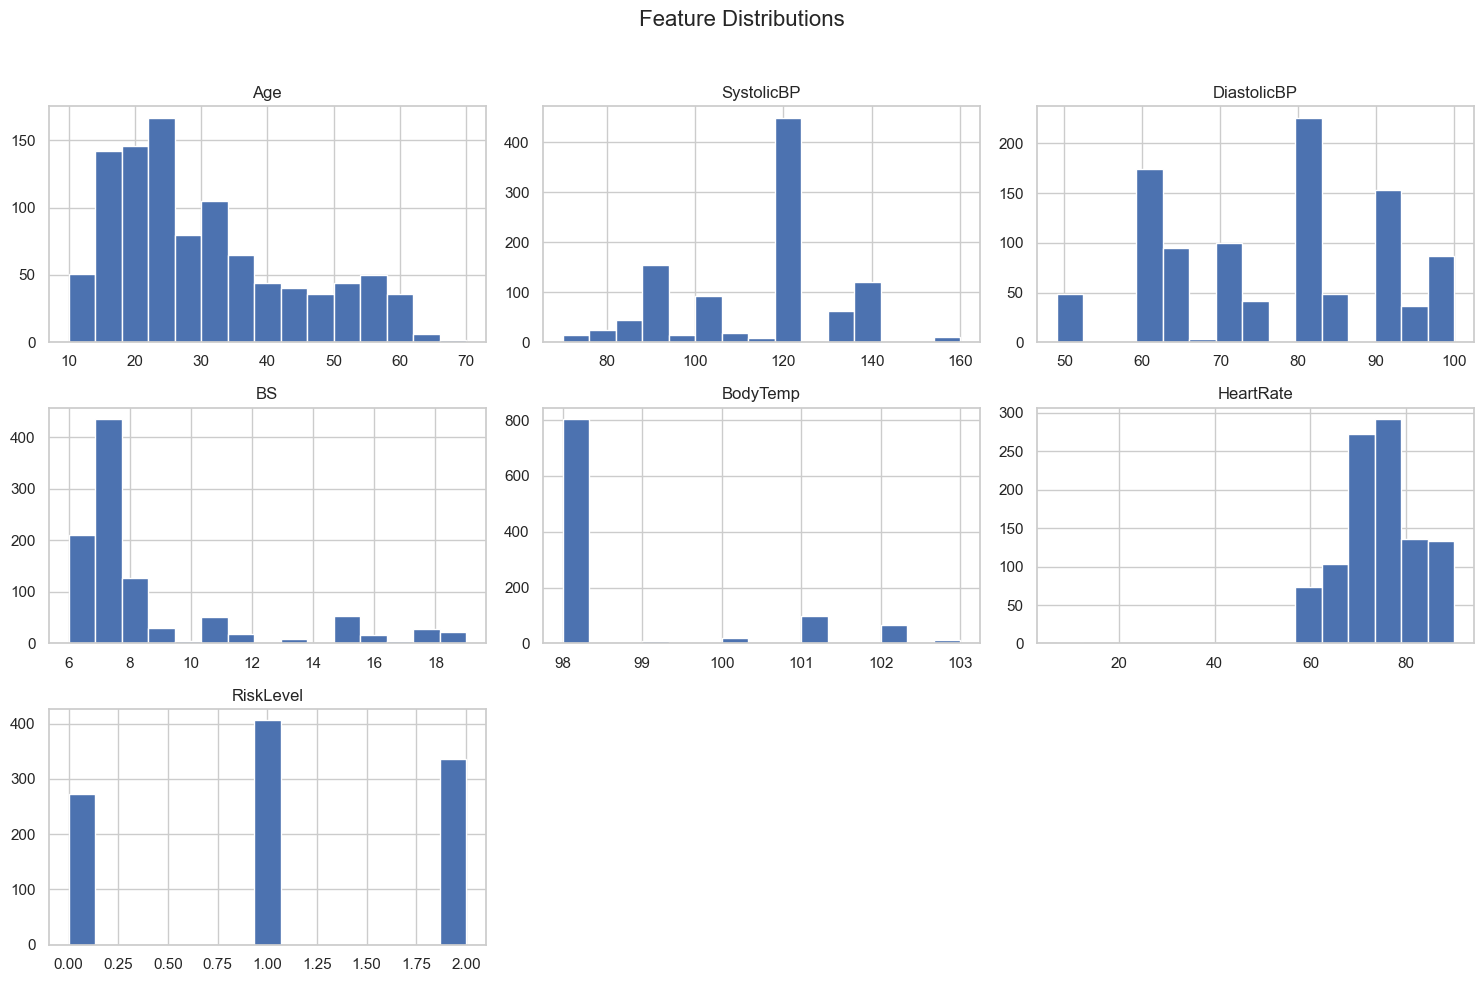

In [90]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Determine the number of features
num_features = data.shape[1]  # Includes all columns

# Calculate the number of rows and columns for the layout
num_rows = (num_features // 3) + (num_features % 3 > 0)  # Adjust for remainder

# Plot histograms for each feature
data.hist(bins=15, figsize=(15, 10), layout=(num_rows, 3))
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the suptitle
plt.show()

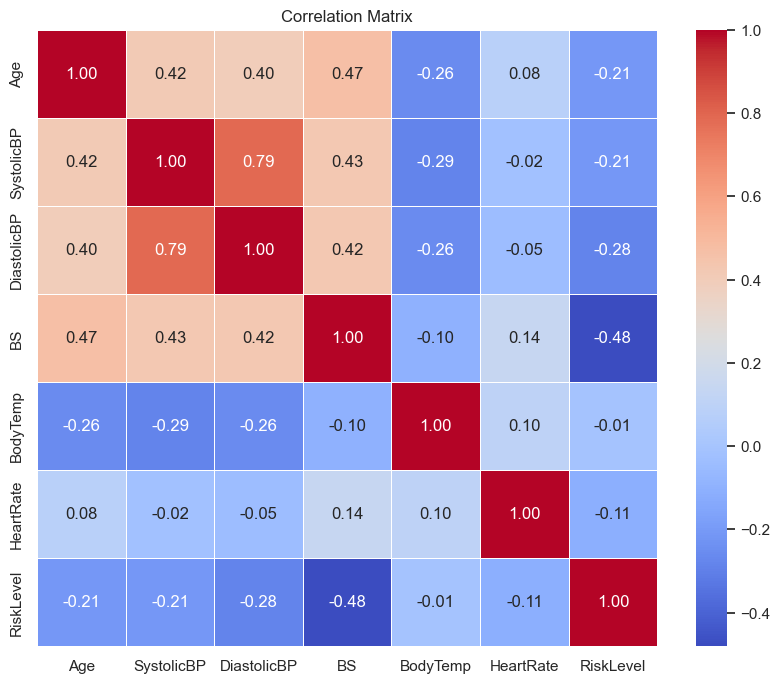

In [91]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [92]:
#There is an observation with heart rate 7, which doesn't make sense
data.HeartRate.mode()
data.loc[data.HeartRate == 7, "HeartRate"] = 70

feature scaling

In [93]:
# Scale numerical features
numerical_features = data.drop('RiskLevel', axis=1).columns
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])


separate the features and target variable

In [94]:
# Separate features and target
X = data.drop('RiskLevel', axis=1)
y = data['RiskLevel']

In [95]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Hyperparameter Tuning 

 to find the best set of hyperparameters for a given machine learning model

In [96]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

In [97]:
# Print best parameters and best score
#print("Best Parameters:", grid_search.best_params_)
#print("Best Score:", grid_search.best_score_)
# Use the best estimator to predict and evaluate
best_rf_classifier = grid_search.best_estimator_
y_pred_best = best_rf_classifier.predict(X_test)


Model Training with Random Forest Classifier 

Train a Random Forest model with feature selection (RFE).

In [98]:
from sklearn.feature_selection import RFE

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Feature selection with RFE
selector = RFE(rf_classifier, n_features_to_select=6)
selector = selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

In [99]:
 #Train the model with selected features
rf_classifier.fit(X_train_selected, y_train)
y_pred_selected = rf_classifier.predict(X_test_selected)

Evaluate the model with selected features

In [100]:
# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred_best)
precision = precision_score(y_test, y_pred_best, average='weighted')
recall = recall_score(y_test, y_pred_best, average='weighted')
f1 = f1_score(y_test, y_pred_best, average='weighted')
classification_rep = classification_report(y_test, y_pred_best)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n", classification_rep)

Accuracy: 0.8177
Precision: 0.8224
Recall: 0.8177
F1 Score: 0.8180

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87        47
           1       0.86      0.76      0.81        80
           2       0.75      0.84      0.80        76

    accuracy                           0.82       203
   macro avg       0.83      0.83      0.83       203
weighted avg       0.82      0.82      0.82       203



Cross-Validation for Random Forest

In [101]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')

# Print cross-validation results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.2f}")


Cross-Validation Scores: [0.79754601 0.77777778 0.84567901 0.88888889 0.83333333]
Mean Cross-Validation Accuracy: 0.83


The scaler is used to transform data during preprocessing, ensuring that new data points are scaled in the same way as the training data

 Model Training with XGBoost

In [102]:
from xgboost import XGBClassifier 

# Initialize and train XGBoost model
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

 Evaluation of XGBoost Model

In [103]:
# Evaluate XGBoost model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')
classification_rep_xgb = classification_report(y_test, y_pred_xgb)

print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")
print(f"XGBoost Precision: {precision_xgb:.4f}")
print(f"XGBoost Recall: {recall_xgb:.4f}")
print(f"XGBoost F1 Score: {f1_xgb:.4f}")
print("\nXGBoost Classification Report:\n", classification_rep_xgb)

XGBoost Accuracy: 0.8424
XGBoost Precision: 0.8427
XGBoost Recall: 0.8424
XGBoost F1 Score: 0.8424

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86        47
           1       0.86      0.82      0.84        80
           2       0.82      0.84      0.83        76

    accuracy                           0.84       203
   macro avg       0.84      0.85      0.85       203
weighted avg       0.84      0.84      0.84       203



Ensemble Methods: Combining XGBoost with Random Forest or using stacking techniques can sometimes yield even better results. You can create a stacking model or use another ensemble technique.

 Train a stacking model combining Random Forest and XGBoost as base models with Logistic Regression as the meta-model

Ensemble Methods: Stacking Classifier

In [104]:
# Define base models for stacking
base_models = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(random_state=42))
]

# Define meta-model for stacking
meta_model = LogisticRegression()
# Initialize stacking classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Train stacking classifier
stacking_model.fit(X_train, y_train)
y_pred_stacking = stacking_model.predict(X_test)

Evaluate Stacking Classifier

In [105]:
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
precision_stacking = precision_score(y_test, y_pred_stacking, average='weighted')
recall_stacking = recall_score(y_test, y_pred_stacking, average='weighted')
f1_stacking = f1_score(y_test, y_pred_stacking, average='weighted')
classification_rep_stacking = classification_report(y_test, y_pred_stacking)

print(f"Stacking Accuracy: {accuracy_stacking:.4f}")
print(f"Stacking Precision: {precision_stacking:.4f}")
print(f"Stacking Recall: {recall_stacking:.4f}")
print(f"Stacking F1 Score: {f1_stacking:.4f}")
print("\nStacking Classification Report:\n", classification_rep_stacking)


Stacking Accuracy: 0.8473
Stacking Precision: 0.8477
Stacking Recall: 0.8473
Stacking F1 Score: 0.8474

Stacking Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87        47
           1       0.86      0.84      0.85        80
           2       0.82      0.84      0.83        76

    accuracy                           0.85       203
   macro avg       0.85      0.85      0.85       203
weighted avg       0.85      0.85      0.85       203



Hyperparameter Tuning for Stacking Classifier

In [106]:
# Define parameter grid for RandomForestClassifier
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Define parameter grid for XGBClassifier
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2]
}

In [107]:
# Initialize base models for Grid Search
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)

# Initialize GridSearchCV for RandomForest
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)
print("Best parameters for RandomForestClassifier:", grid_search_rf.best_params_)

# Initialize GridSearchCV for XGBClassifier
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train, y_train)
print("Best parameters for XGBClassifier:", grid_search_xgb.best_params_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for XGBClassifier: {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200}


In [108]:
# Define best models based on grid search results
best_rf = grid_search_rf.best_estimator_
best_xgb = grid_search_xgb.best_estimator_

# Create a stacking classifier with best base models
best_stacking_model = StackingClassifier(
    estimators=[('rf', best_rf), ('xgb', best_xgb)],
    final_estimator=meta_model,
    cv=5
)
# Train stacking classifier with best base models
best_stacking_model.fit(X_train, y_train)
y_pred_best_stacking = best_stacking_model.predict(X_test)


In [109]:
# Evaluate the best stacking model
accuracy_best_stacking = accuracy_score(y_test, y_pred_best_stacking)
precision_best_stacking = precision_score(y_test, y_pred_best_stacking, average='weighted')
recall_best_stacking = recall_score(y_test, y_pred_best_stacking, average='weighted')
f1_best_stacking = f1_score(y_test, y_pred_best_stacking, average='weighted')
classification_rep_best_stacking = classification_report(y_test, y_pred_best_stacking)

print(f"Best Stacking Accuracy: {accuracy_best_stacking:.4f}")
print(f"Best Stacking Precision: {precision_best_stacking:.4f}")
print(f"Best Stacking Recall: {recall_best_stacking:.4f}")
print(f"Best Stacking F1 Score: {f1_best_stacking:.4f}")
print("\nBest Stacking Classification Report:\n", classification_rep_best_stacking)

Best Stacking Accuracy: 0.8424
Best Stacking Precision: 0.8427
Best Stacking Recall: 0.8424
Best Stacking F1 Score: 0.8424

Best Stacking Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86        47
           1       0.86      0.82      0.84        80
           2       0.82      0.84      0.83        76

    accuracy                           0.84       203
   macro avg       0.84      0.85      0.85       203
weighted avg       0.84      0.84      0.84       203



In [110]:
# Save the trained stacking model and preprocessing objects
joblib.dump(best_stacking_model, 'best_stacking_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [111]:
# Save the trained model and preprocessing objects
#joblib.dump(rf_classifier, 'rf_model.pkl')
#joblib.dump(scaler, 'scaler.pkl')
#joblib.dump(label_encoder, 'label_encoder.pkl')
